In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [44]:
def scale_C_t(scale, alpha_t, scores, sigma_t, t, interval=50):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = (sigma_t) + scale *(abs(sigma_t) * Q)
    negative_v = (sigma_t) - scale *(abs(sigma_t) * Q)
    return negative_v, positve_v

def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

def scaled_ACI(coverage_target: float, timeseries_data: tuple, gamma: float, custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(3, custom_interval - 2*error_counter), i)
        scale = 1 + (custom_interval - look_back)/custom_interval

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)

        #alpha_t = min(max(alpha_t_list[-1] + (gamma * (coverage_target - error_t)), 0), 1)
        #alpha_t_list.append(alpha_t)

        if error_t:
                error_counter+=1
        else:
            error_counter = max(-3, error_counter-1)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI',
        'coverage_target': coverage_target,
        'gamma': gamma,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_size': custom_interval
    }

In [58]:
def scale_C_t(scale, alpha_t, scores, sigma_t, t, interval=50):
    alpha_t = min(1, max(0, alpha_t))
    Q = np.quantile(scores[t-interval:t], 1 - alpha_t)
    positve_v = (sigma_t) + scale *(abs(sigma_t) * Q)
    negative_v = (sigma_t) - scale *(abs(sigma_t) * Q)
    return negative_v, positve_v

def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1

def parameter_lookback(coverage_target: float, timeseries_data: tuple, mu: int, sigma: float,  custom_interval: int) -> dict:
    xpred, y = timeseries_data
    alpha_t_list = [coverage_target]

    All_scores = (abs(y - xpred))/abs(xpred)

    err_t_list = []
    conformal_sets_list = []
    
    error_counter = 0
    for i in range(custom_interval+1, len(All_scores)):
        # Look back window
        look_back = min(max(round(mu), round(custom_interval - error_counter)), i)
        scale = 1 + (custom_interval - look_back)/custom_interval

        Coverage_t = scale_C_t(scale, alpha_t_list[-1], All_scores, xpred[i], i, look_back)
        conformal_sets_list.append(Coverage_t)

        error_t = err_t(y[i], Coverage_t)
        err_t_list.append(error_t)


        if error_t:
                error_counter+=sigma
        else:
            error_counter = max(-mu, error_counter-sigma)

        

    # Calculating different averages
    realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(custom_interval).mean().mean()
    average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

    return {
        'model': 'scaled_ACI',
        'coverage_target': coverage_target,
        'realised_interval_coverage': realised_interval_coverage,
        'alpha_t_list': alpha_t_list,
        'average_prediction_interval': average_prediction_interval,
        'conformal_sets': conformal_sets_list,
        'error_t_list': err_t_list, 
        'interval_size': custom_interval
    }

In [46]:
print(type(round(1.5)))

<class 'int'>


In [47]:
from ConformalMethods import ACP_data
dataloader = ACP_data(100, 1200, dist_shifts=[(-1, 5), (5, 5), (5, 10)]) #, (20, 20), (30, 30)])
all_data = dataloader.generate()

Widths: my method 25.54049385647464 ACI 28.237999482663344
Coverage:my method 0.7099236641221374 ACI 0.6884732824427481
Covearge Variance: my method 0.20354583359983433 ACI 0.2121347794437896


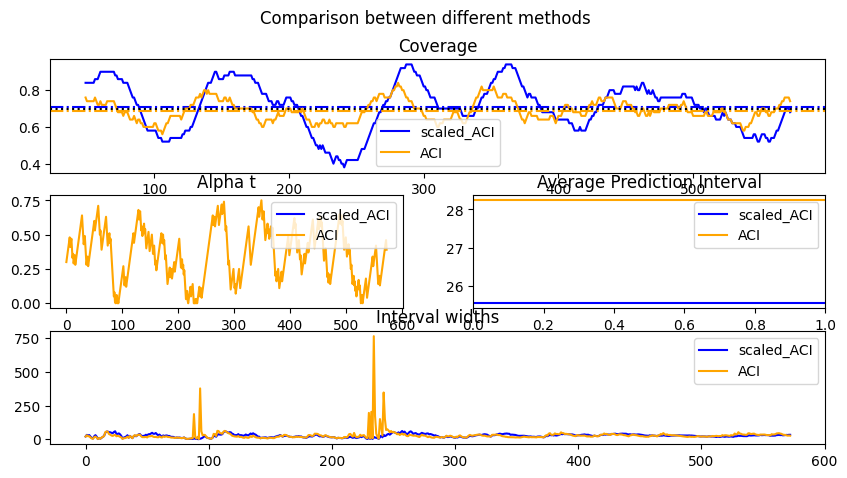

Widths: my method 26.2122945785369 ACI 27.520920276168646
Coverage:my method 0.7021099802092168 ACI 0.6921070115917445
Covearge Variance: my method 0.20883717042208455 ACI 0.2102034757192559


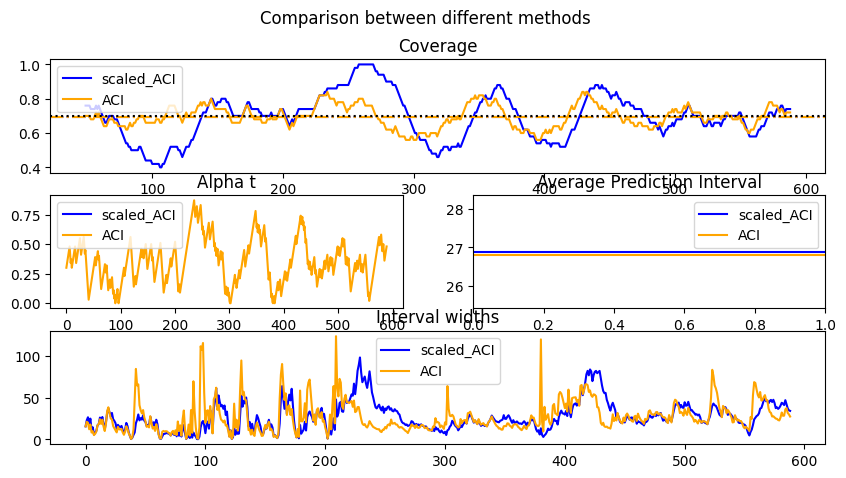

Widths: my method 26.035318089166065 ACI 27.469519582757385
Coverage:my method 0.7133211335505566 ACI 0.6961179882914837
Covearge Variance: my method 0.1924979175343607 ACI 0.21040712203248652


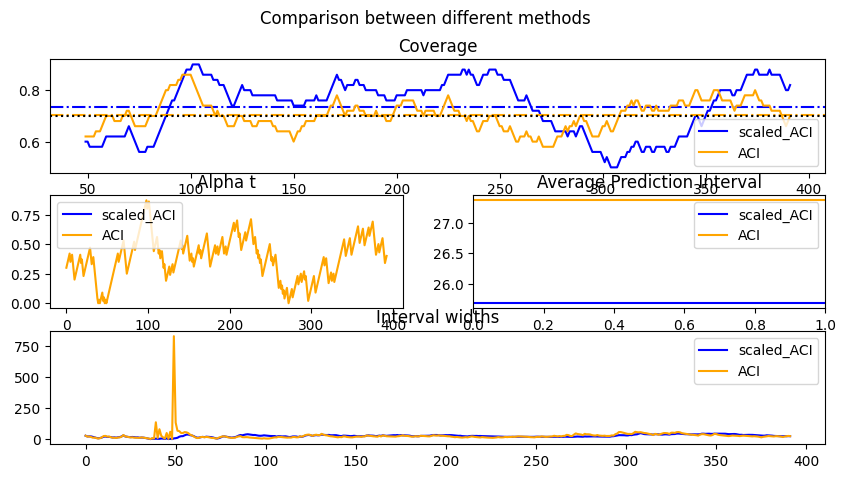

Widths: my method 26.56155092791945 ACI 28.34250530378671
Coverage:my method 0.7060104354163736 ACI 0.6975089981310552
Covearge Variance: my method 0.2146133437350234 ACI 0.20995636760618822


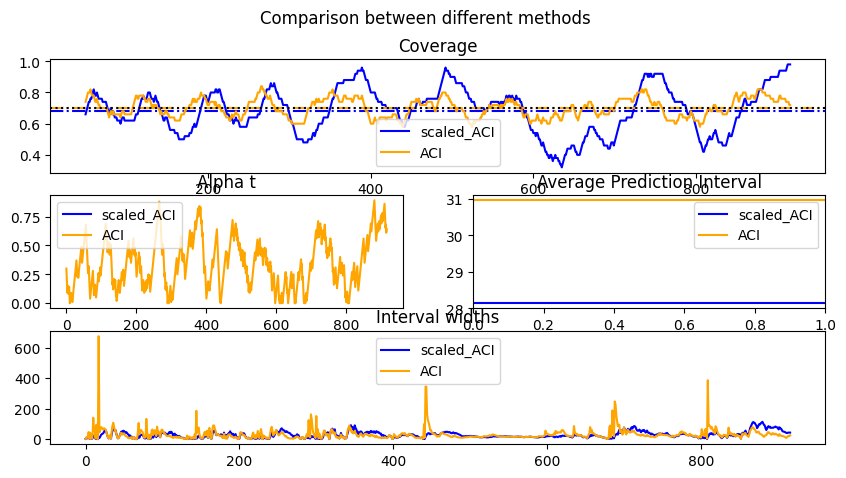

Widths: my method 25.51063691297791 ACI 27.093329560058635
Coverage:my method 0.7011542463375335 ACI 0.6973952251123829
Covearge Variance: my method 0.21276845116270324 ACI 0.20945133851024053


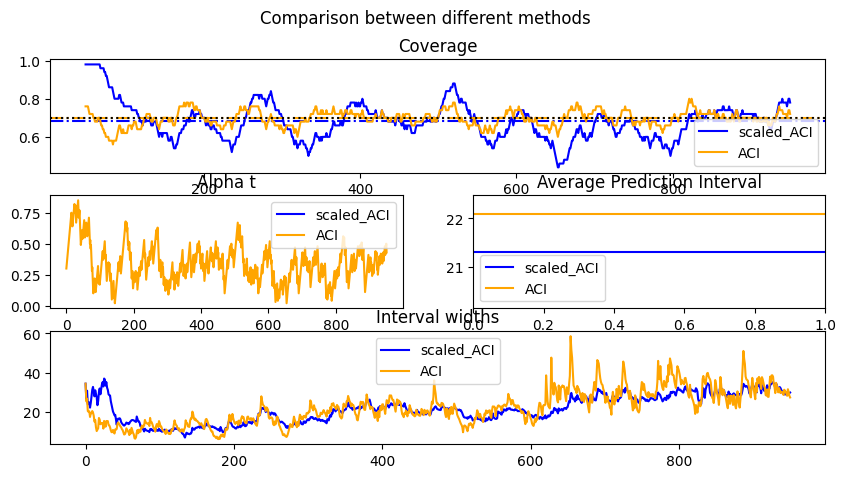

Widths: my method 25.002411335704362 ACI 26.386039234725306
Coverage:my method 0.7009827487746669 ACI 0.6973074335922607
Covearge Variance: my method 0.20500459136822777 ACI 0.20969639577594118
Widths: my method 25.316672017020412 ACI 27.40038940455121
Coverage:my method 0.7045233084735241 ACI 0.6967920859362234
Covearge Variance: my method 0.20111063364047094 ACI 0.21260633284346425
Widths: my method 24.705837818881996 ACI 26.626613278797734
Coverage:my method 0.7016763966169441 ACI 0.6967816109490196
Covearge Variance: my method 0.21579488958261073 ACI 0.2112799167533819
Widths: my method 24.348590674896098 ACI 26.220661008290683
Coverage:my method 0.7007185253879009 ACI 0.6966639010904865
Covearge Variance: my method 0.22028801836430917 ACI 0.21316228382183267
Widths: my method 24.748292232313325 ACI 26.260201731624885
Coverage:my method 0.7003064429640534 ACI 0.6964044075331619
Covearge Variance: my method 0.21394546989501062 ACI 0.21269511616094042
Widths: my method 24.83402914693

In [63]:
from ConformalMethods import ACP_plots
from ConformalMethods import AdaptiveCP

ACP = AdaptiveCP(0.3)

records = [[], []]
coverage_records = [[], []]

for i, data in enumerate(all_data):
    scaled = parameter_lookback(0.3, data, 5, 0.5, 50)
    non_adaptive = ACP.ACI(data, 0.1)
    records[0].append(scaled['average_prediction_interval'])
    records[1].append(non_adaptive['average_prediction_interval'])
    coverage_records[0].append(scaled['realised_interval_coverage'])
    coverage_records[1].append(non_adaptive['realised_interval_coverage'])

    print('Widths: my method', np.mean(records[0]), 'ACI', np.mean(records[1]))
    print('Coverage:my method', np.mean(coverage_records[0]), 'ACI', np.mean(coverage_records[1]))
    print('Covearge Variance: my method', np.var(scaled['error_t_list']) , 'ACI', np.var(np.array(non_adaptive['error_t_list'])))

    if i <5:
        ACP_plots.compare_many([scaled, non_adaptive])

Seems to be performing well however we are observing that it can seriously over cover, experiment with allowing window to get bigger. This acctualy does the opposite and makes it under cover, as i imagine the windows are smaller than they need to be. With a smaller min it is allowed it is performing better, I am wondering though to what extent I am optimising for the data and whether the method is acctualy robust, I feel like there may need to be some sort of adaptive method. Variance of the coverage is much higher meaning that it isnt realy learning the proper windows, but this makes sense as it is quite litteraly correcting its mistakes will need a fancier method if you want to avoid this, thinking that the widths should be somewhat learnt.

[(1.0, 0.5), (1.0, 2.0), (1.0, 3.5), (1.0, 5.0), (3.0, 0.5), (3.0, 2.0), (3.0, 3.5), (3.0, 5.0), (5.0, 0.5), (5.0, 2.0), (5.0, 3.5), (5.0, 5.0)]


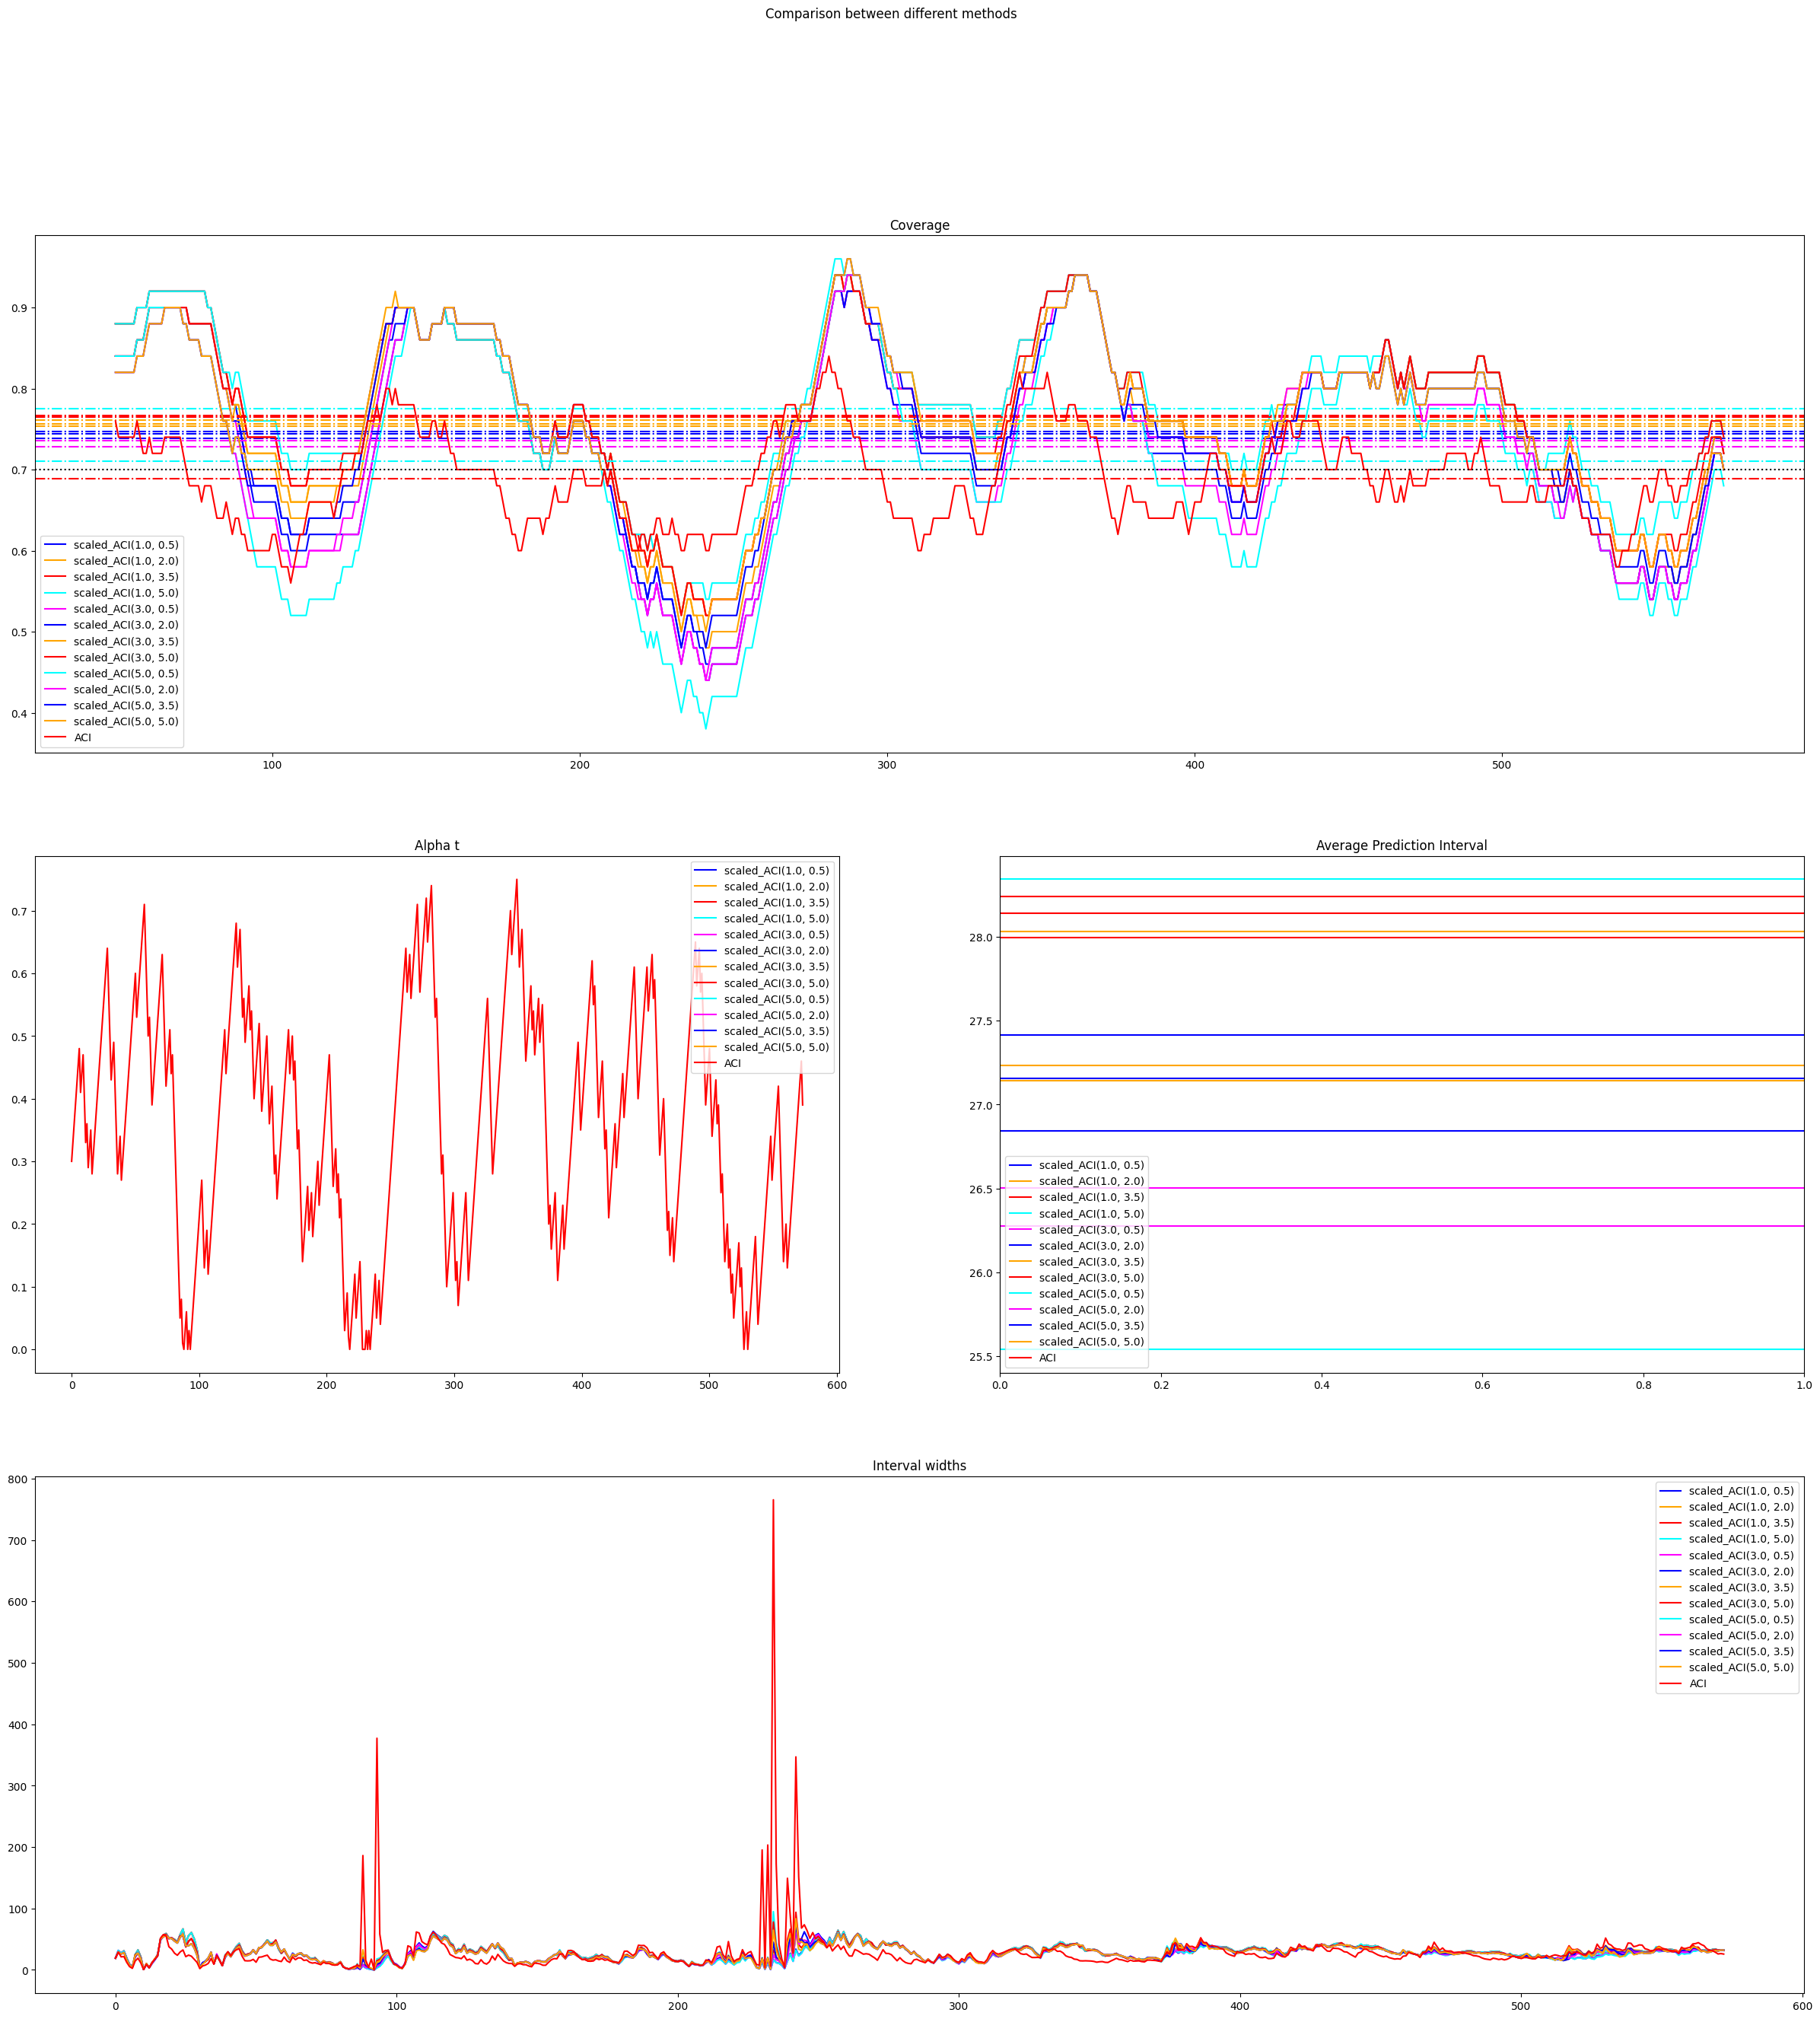

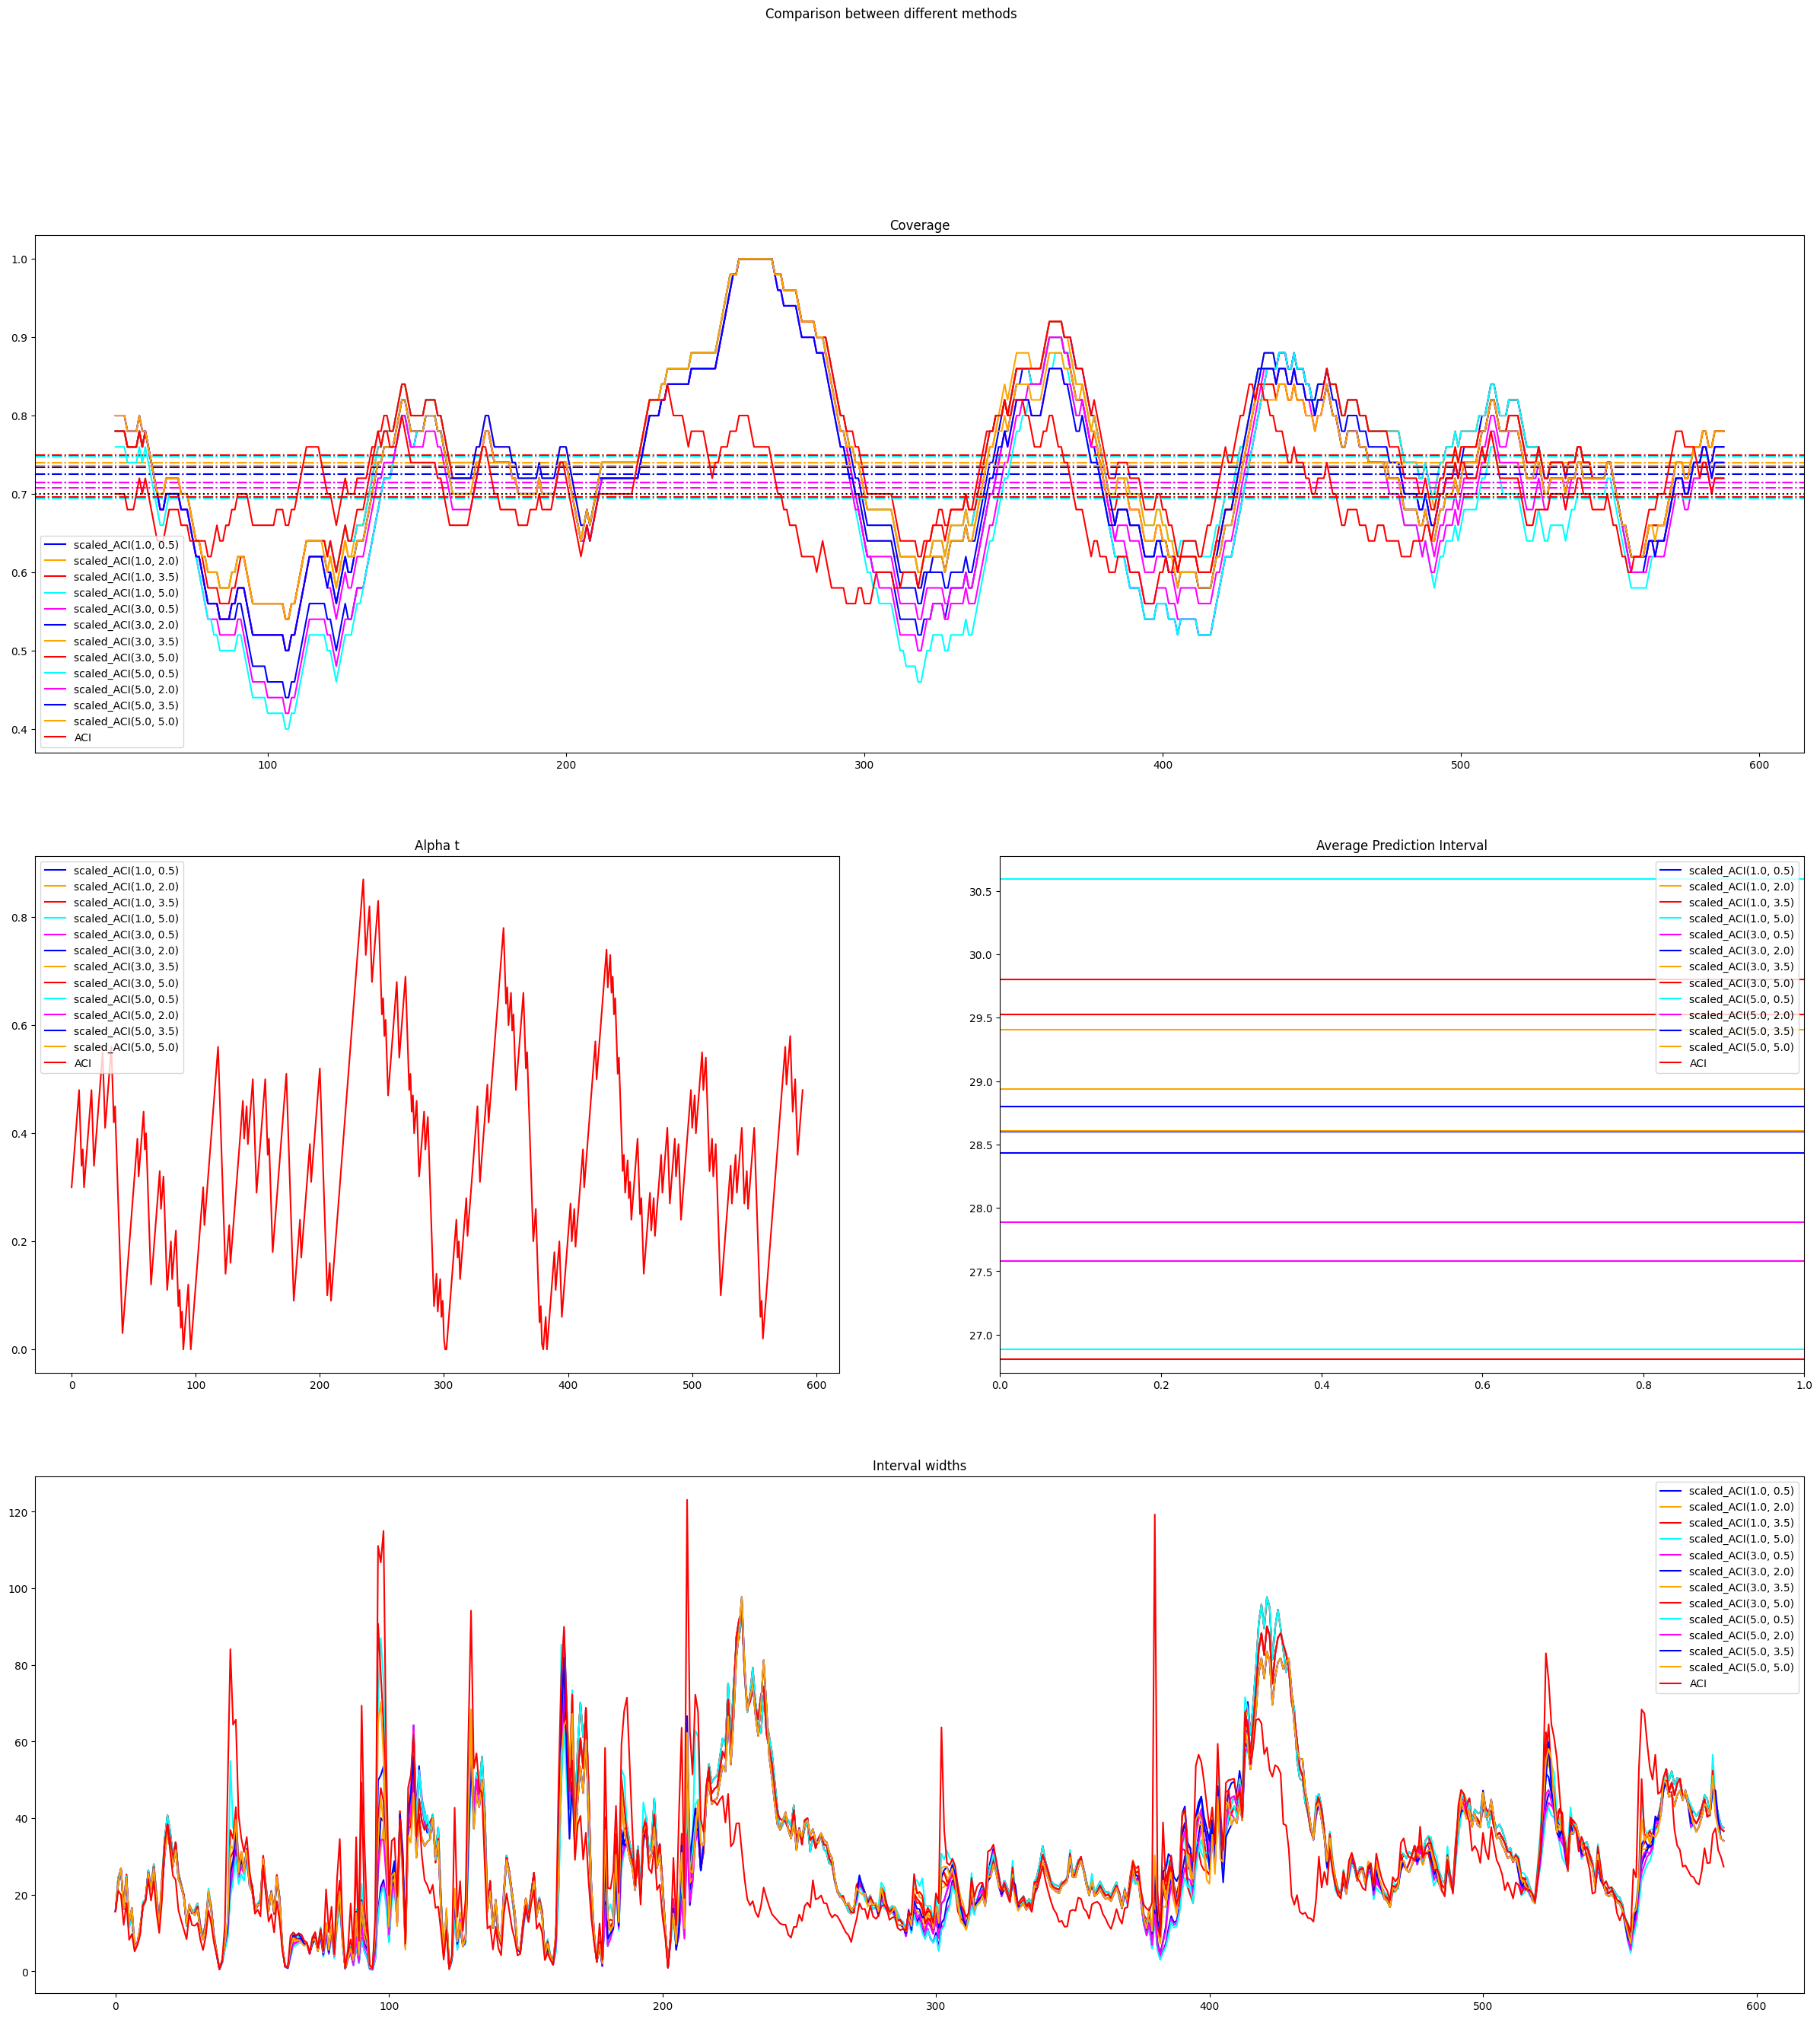

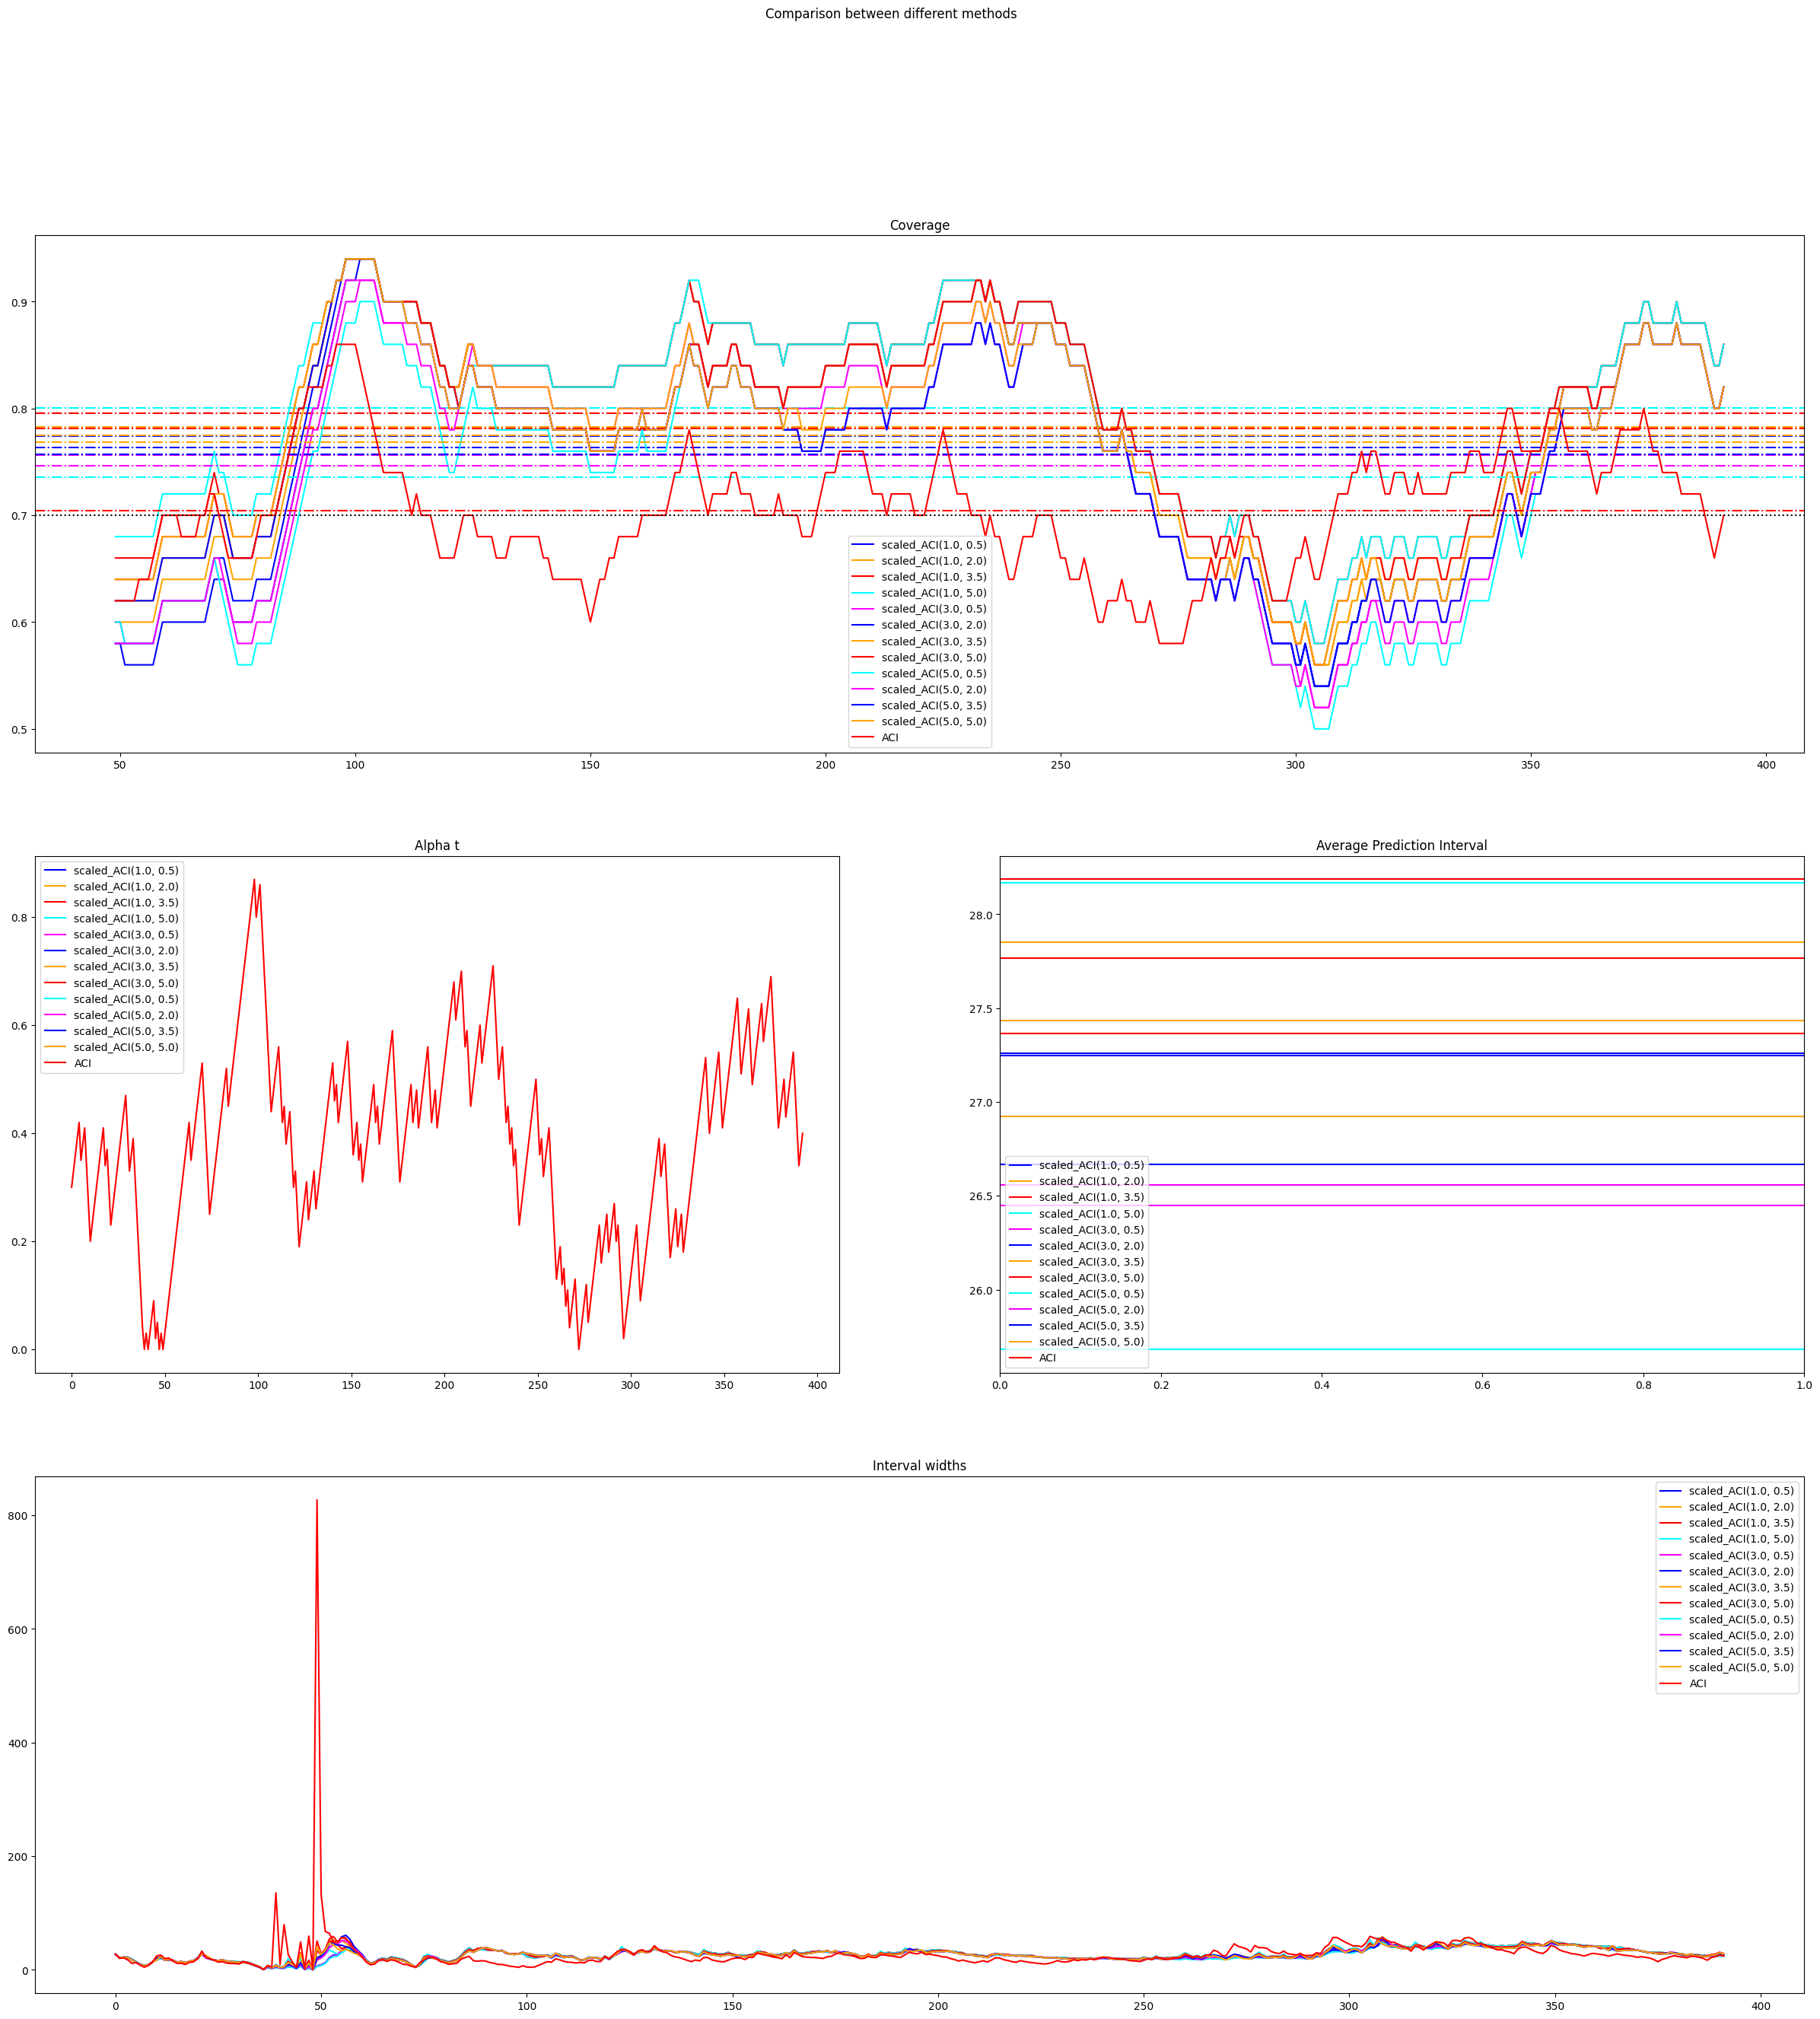

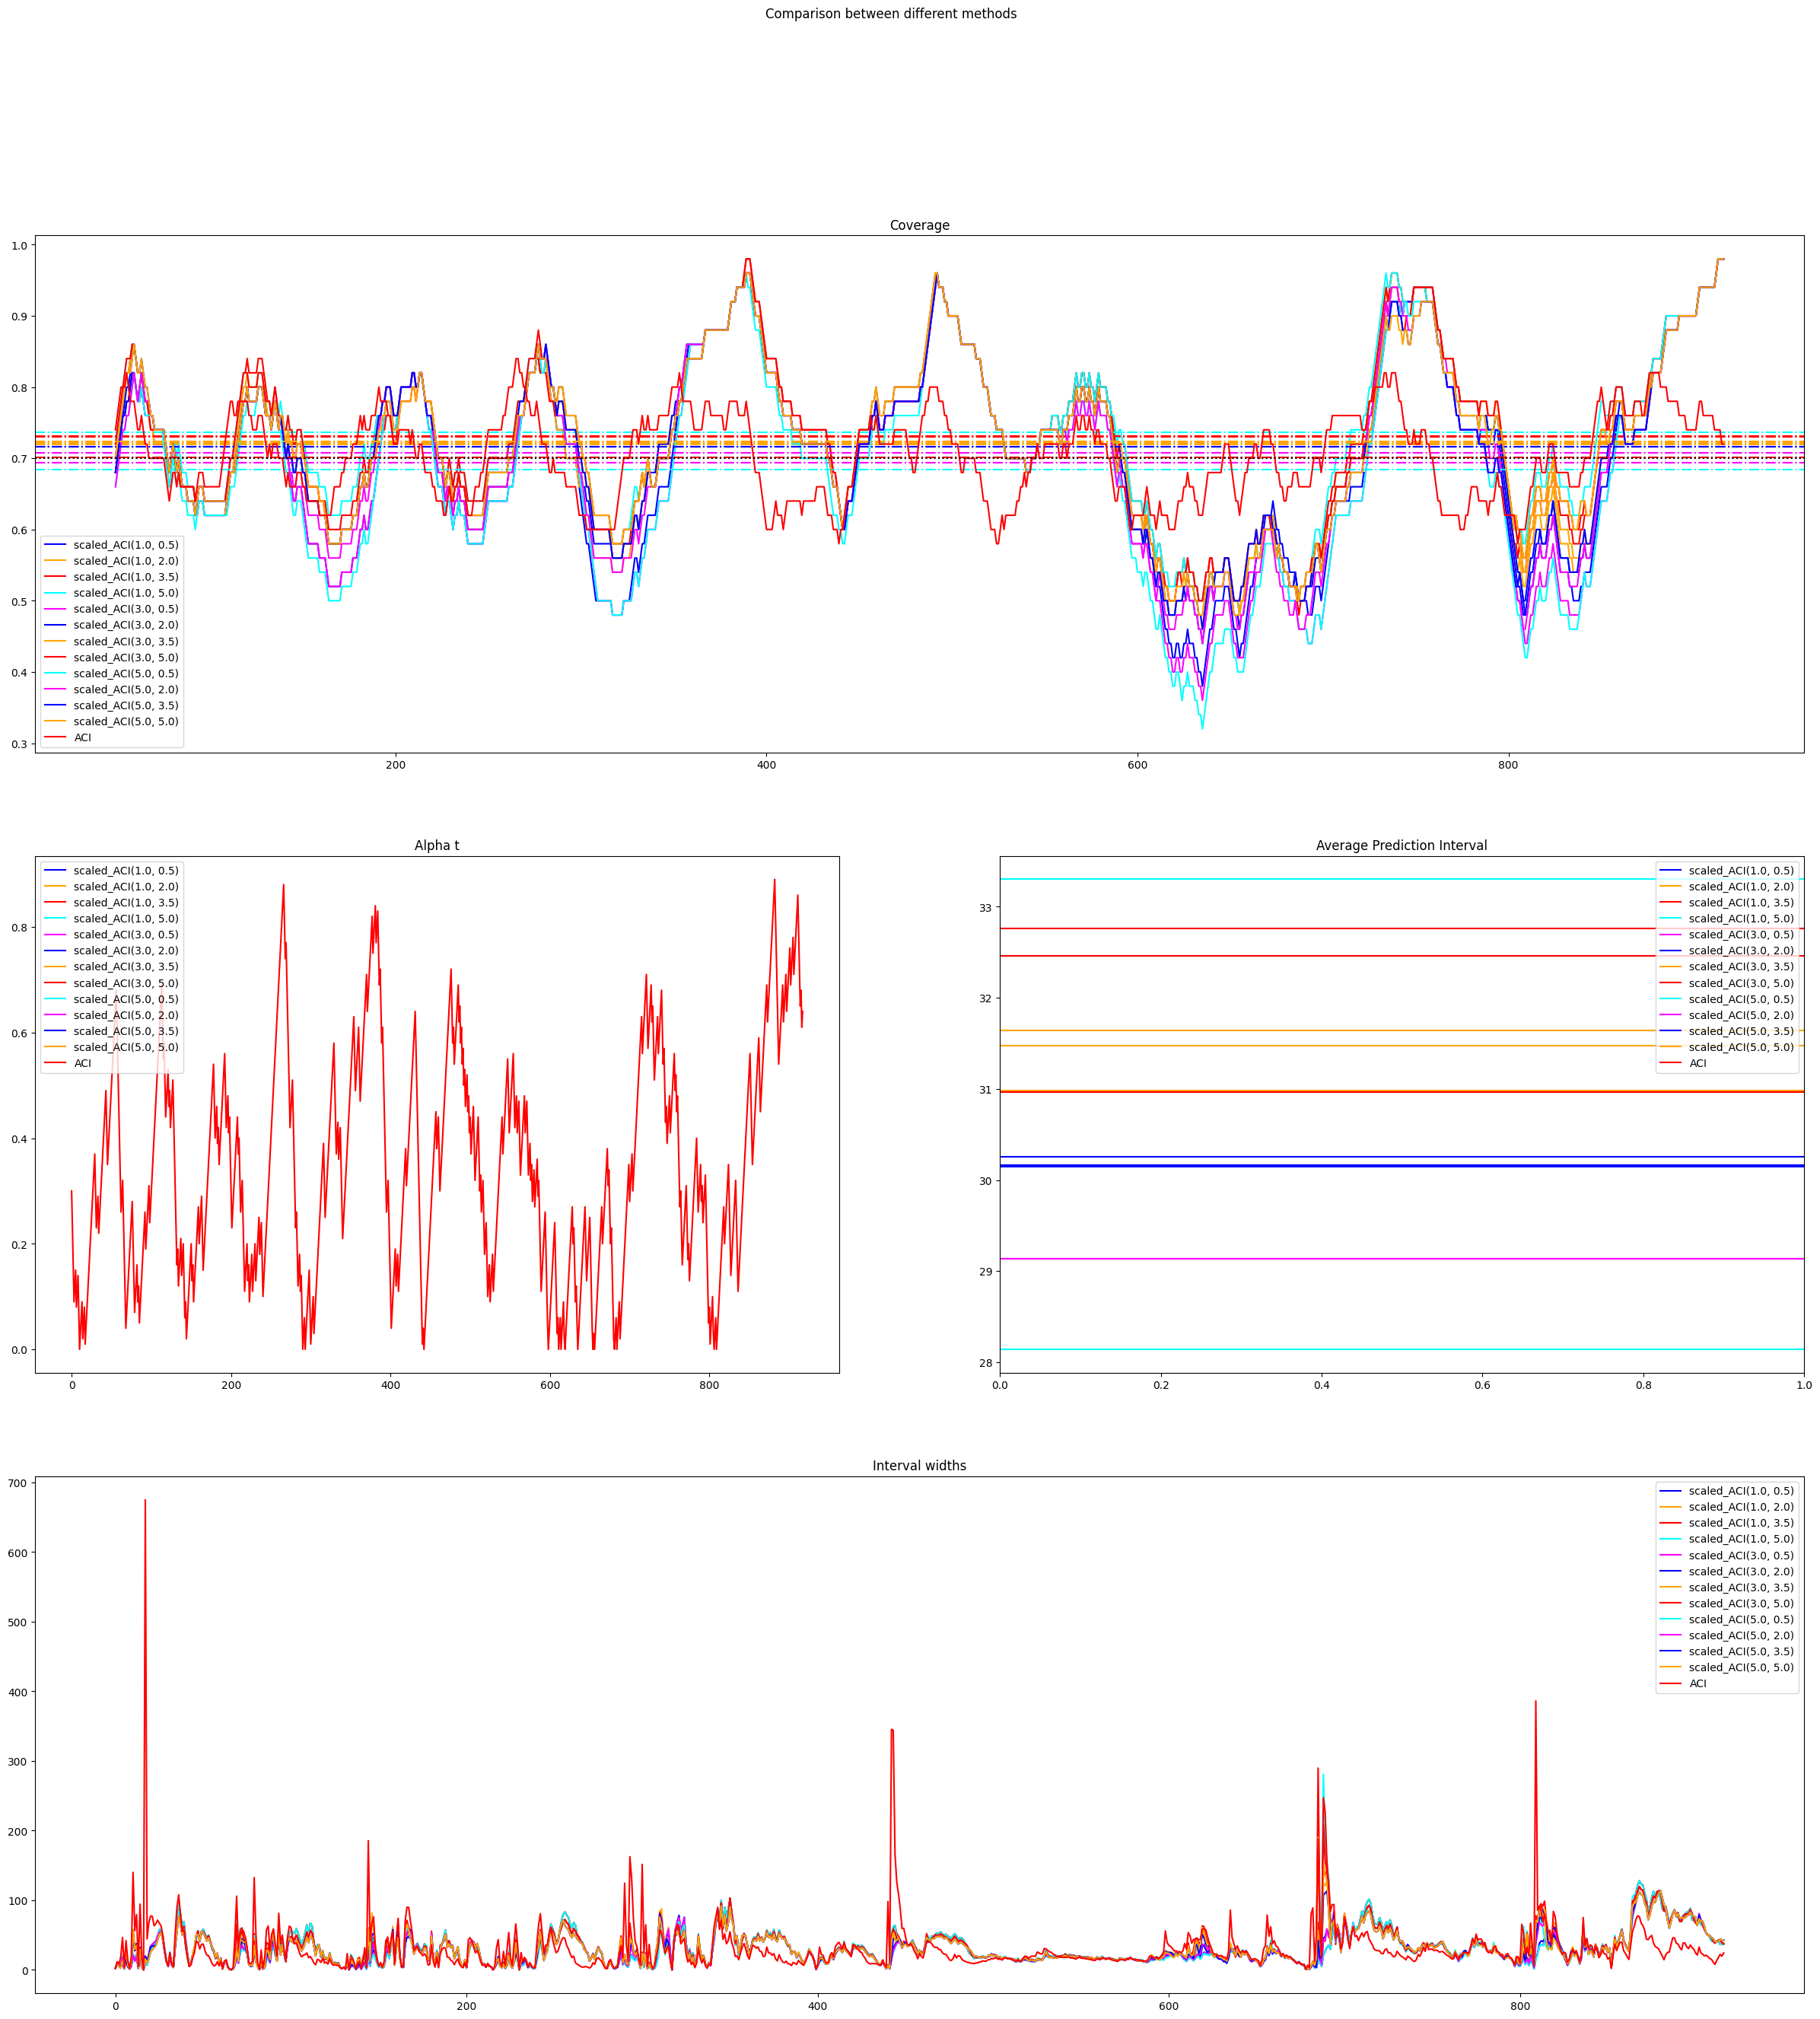

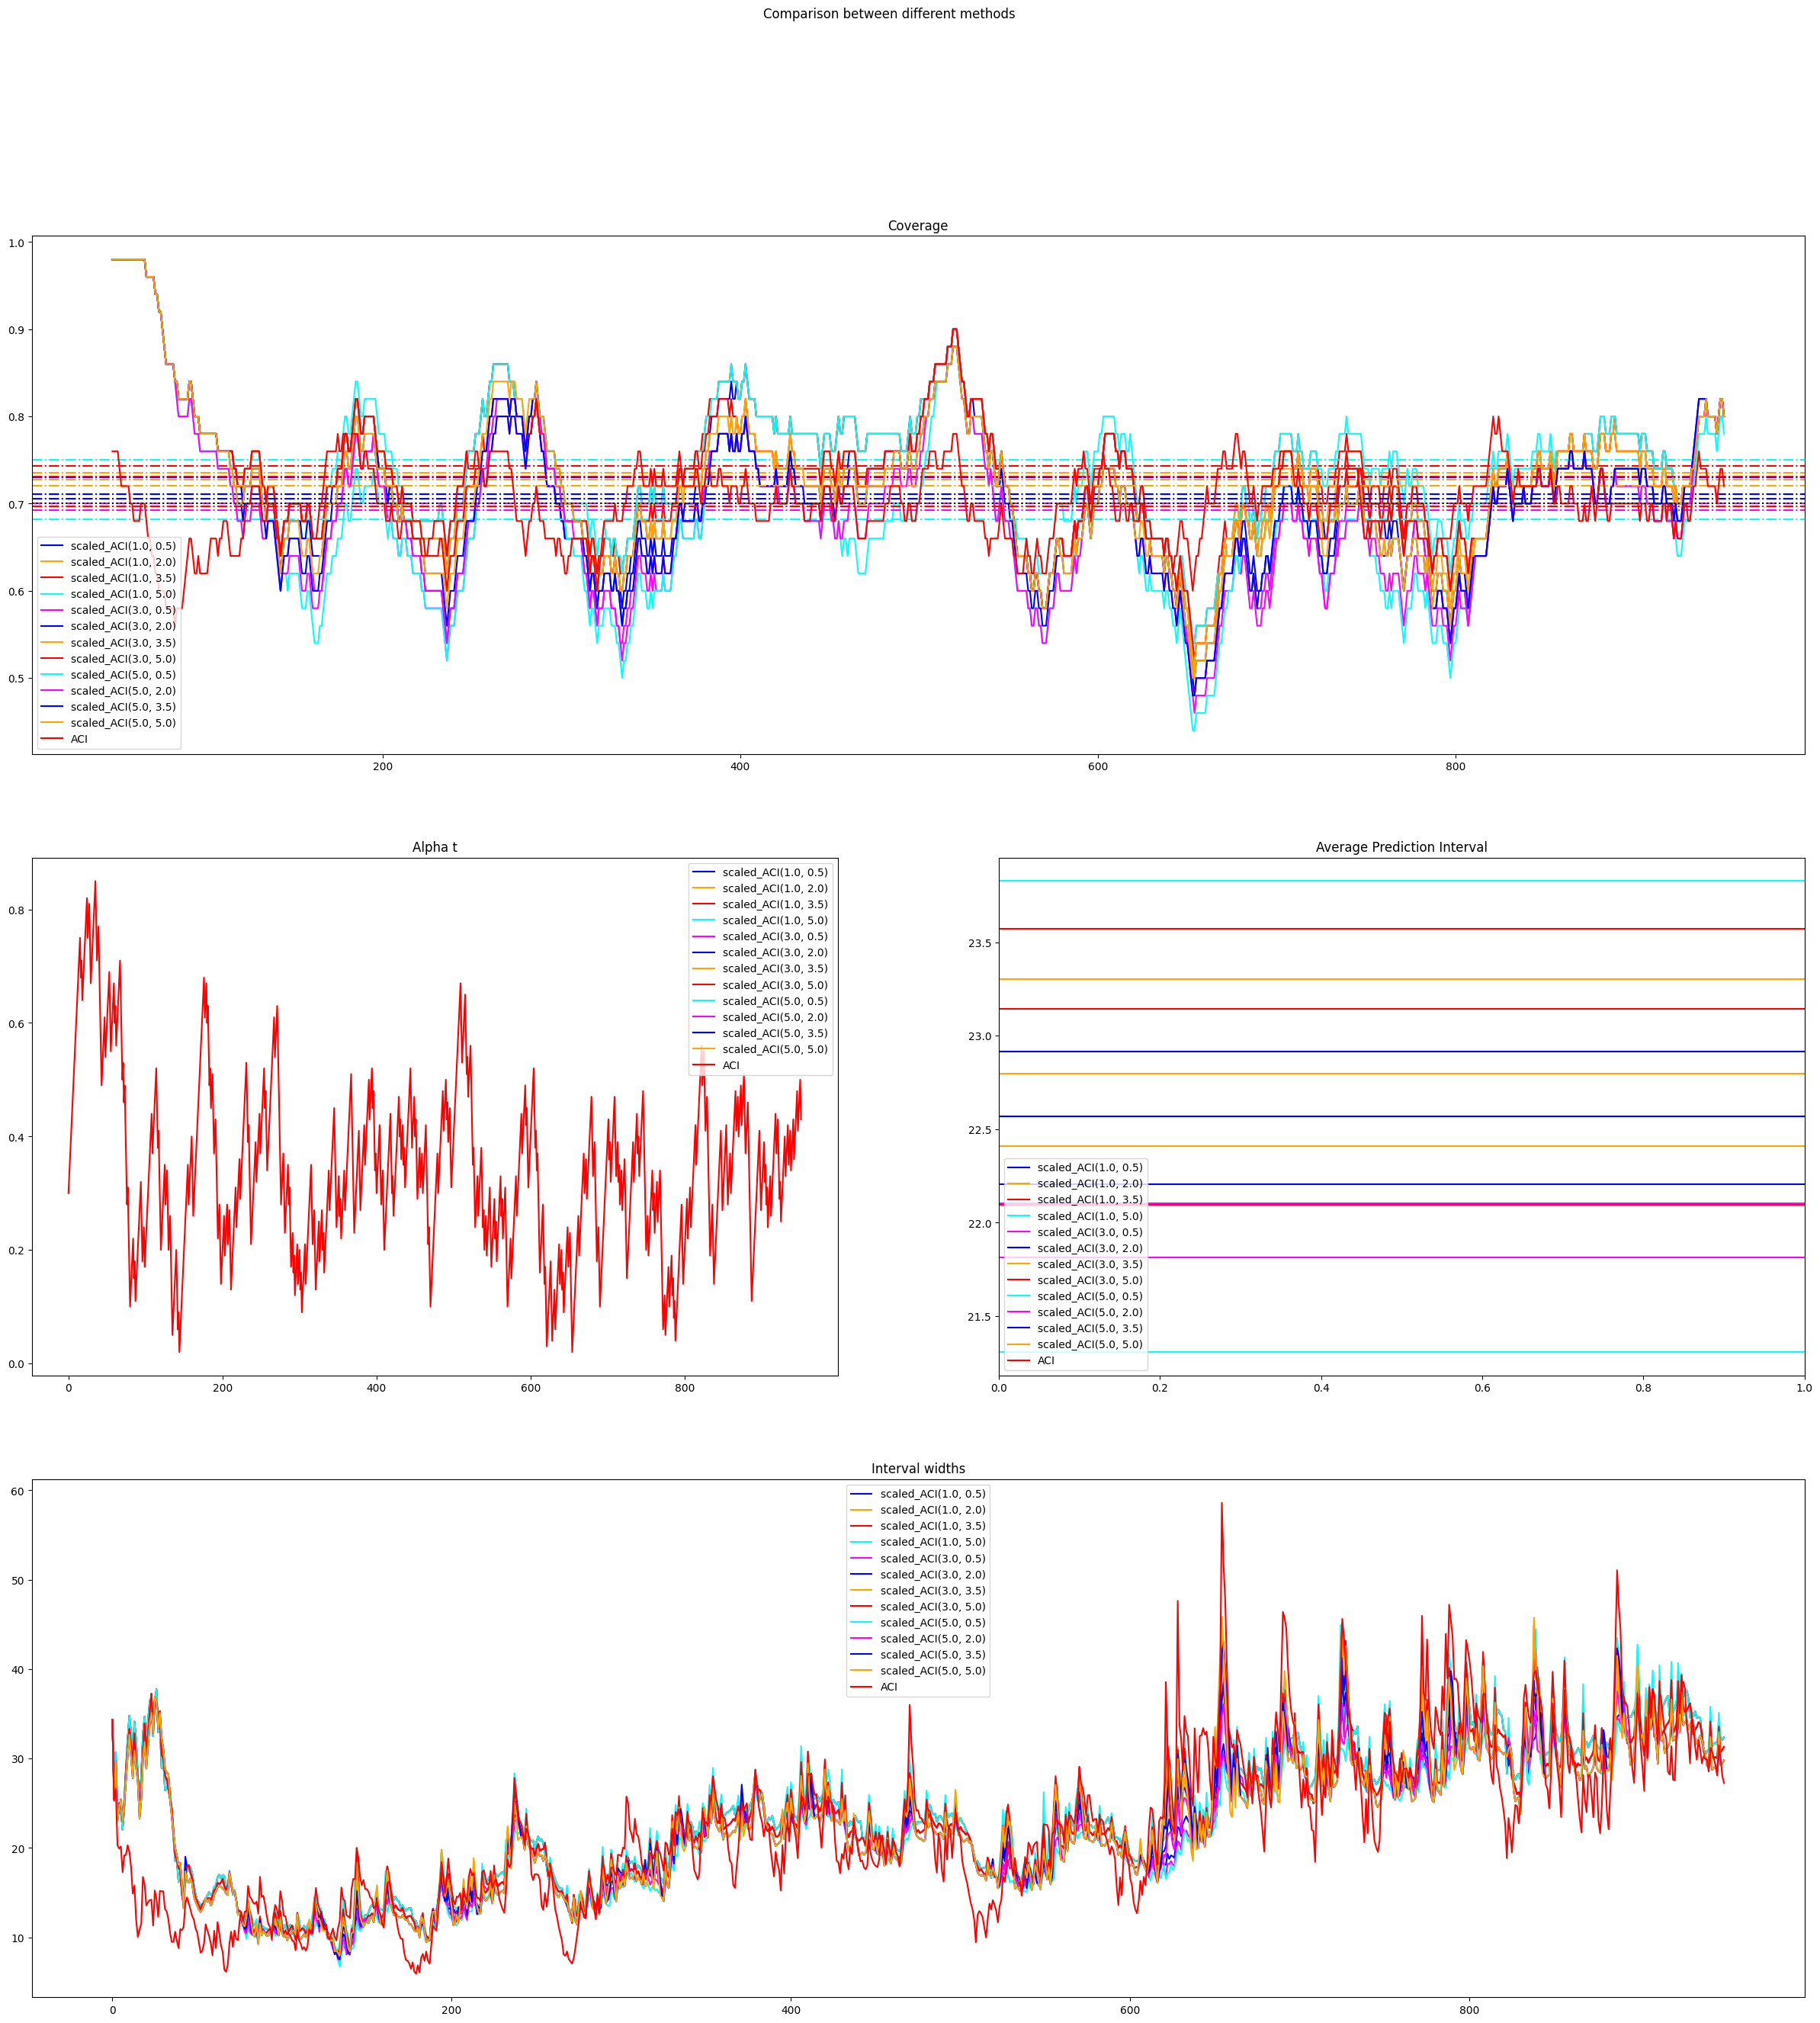

TypeError: slice indices must be integers or None or have an __index__ method

In [62]:
from ConformalMethods import ACP_plots
from ConformalMethods import AdaptiveCP
import itertools

ACP = AdaptiveCP(0.3)

records = [[], []]
coverage_records = [[], []]

paramtext = list(itertools.product(np.linspace(1, 5, 3).tolist(), np.linspace(0.5, 5, 4).tolist()))
print(paramtext)


for i, data in enumerate(all_data):
    all_param_lookback = []
    
    for param in paramtext:
        scaled = parameter_lookback(0.3, data, param[0], param[1], 50)
        scaled['model'] = scaled['model'] + str(param)
        all_param_lookback.append(scaled)

    Aci = ACP.ACI(data, 0.1)


    # records[0].append(scaled['average_prediction_interval'])
    # records[1].append(non_adaptive['average_prediction_interval'])
    # coverage_records[0].append(scaled['realised_interval_coverage'])
    # coverage_records[1].append(non_adaptive['realised_interval_coverage'])

    # print('Widths: my method', np.mean(records[0]), 'ACI', np.mean(records[1]))
    # print('Coverage:my method', np.mean(coverage_records[0]), 'ACI', np.mean(coverage_records[1]))
    # print('Covearge Variance: my method', np.var(scaled['error_t_list']) , 'ACI', np.var(np.array(non_adaptive['error_t_list'])))
    all_param_lookback.append(Aci)
    if i <5:
        ACP_plots.compare_many(all_param_lookback, figsize=(30,30))

We observe that this performs better than non adaptive when is good when the data is getting larger and larger, but the current implementation cant deal with when over covering.

In [36]:
from ConformalMethods import ACP_data
second_dataloader = ACP_data(100, 600, dist_shifts=[(30, 30), (20, 20), (10, 10), (0, 5)])
second_data = second_dataloader.generate()

In [37]:
# av = []
# for i, data in enumerate(second_data):
#     dt = ACP.DtACI(data)
#     av.append(dt['average_prediction_interval'])
#     print('dt', np.mean(av))

In [38]:
from ConformalMethods import ACP_data
dataloader = ACP_data(5, 600)
all_data = dataloader.generate()

In [39]:
records2 = [[], []]
for i, data in enumerate(second_data):
    scaled = scaled_ACI(0.3, data, 0.1, 50)
    non_adaptive = ACP.ACI(data, 0.1)
    records2[0].append(scaled['average_prediction_interval'])
    records2[1].append(non_adaptive['average_prediction_interval'])
    print('scaled', np.mean(records2[0]), 'ACI', np.mean(records2[1]))
    
    

scaled 64.55953381418294 ACI 50.275027331136734
scaled 65.42403186978021 ACI 58.633342833570325
scaled 69.6734305573388 ACI 57.67366143733707
scaled 79.60782017532819 ACI 61.46031378426841
scaled 83.14155783847423 ACI 62.388015997148116
scaled 81.24048925541875 ACI 66.19090606894825
scaled 81.38355506836221 ACI 70.55061442033666
scaled 81.9962439977253 ACI 69.8095181245658
scaled 80.36311245879541 ACI 68.59612624790928
scaled 83.55625755336128 ACI 67.64531850397701
scaled 85.99305016518002 ACI 67.80485358746635
scaled 86.75018338861122 ACI 71.57865347978488
scaled 85.9951268327398 ACI 70.67798694779125
scaled 85.00937307268984 ACI 70.30735224210436
scaled 86.5483614280872 ACI 71.76496074820251
scaled 85.25390974991956 ACI 70.91747850226969
scaled 86.94772525040392 ACI 71.58706260295781
scaled 86.53533692668556 ACI 70.94270870979473
scaled 87.2153409026357 ACI 71.87862539241051
scaled 87.3351189013513 ACI 72.76651615917021
scaled 87.34553412909233 ACI 73.8294288008784
scaled 86.51210086

It does seem to be performing worse. On the data which is getting smaller. It is occasionaly well below suggesting that it is more robust.